In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
pkmn = pd.read_csv('Pokemon_with_correct_pkmn_numbers.csv')
pkmn.rename(columns=({'#':'Number', 'Total':'Total Stats'}), inplace=True)
# This way the index starts at 1 and we can correctly join pkmn and combats tables later
pkmn.index = pkmn.index + 1

combats = pd.read_csv("./pokemon_data/combats.csv")

In [3]:
# Note that while Number is not unique, as pokemon like Venusaur and Mega Venusaur both have Number 3, their row index is unique.  This is important bc our combats data keeps track of winners using a pokemon's row index, NOT its pokemon number.  
pkmn.head()

,Number,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
5,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
print(F"The pkmn df has row index starting at {pkmn.index.min()} and ending at {pkmn.index.max()}")
print(F"While the min pkmn.Number is {pkmn.Number.min()} and the max pkmn.Number is {pkmn.Number.max()}")

The pkmn df has row index starting at 1 and ending at 800
While the min pkmn.Number is 1 and the max pkmn.Number is 721


In [5]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [6]:
# Looking at our combats data, our max number for Winner is 800.  This is because a winning pokemon is identified by the row index in the pkmn df.  Winner DOES NOT correspond to pkmn Number.
combats['Winner'].describe()

count    50000.000000
mean       408.890100
std        231.159961
min          1.000000
25%        206.000000
50%        422.000000
75%        606.000000
max        800.000000
Name: Winner, dtype: float64

# Joins

## Identify names of pokemon in winning battles

In [7]:
# Join combats to pkmn table using the row indices (1, 800) for the pkmn table.  This ensures that a pokemon like Venusaur vs. Mega Venusaur will each have their own appropriate number of wins. 
combats_join = pd.merge(combats, pkmn[['Name']], left_on='Winner', right_index=True, how='left')
combats_join.rename(columns={'Name':"winner_name"}, inplace=True)
combats_join.head()

,First_pokemon,Second_pokemon,Winner,winner_name
0,266,298,298,Nuzleaf
1,702,701,701,Terrakion
2,191,668,668,Beheeyem
3,237,683,683,Druddigon
4,151,231,151,Omastar


In [8]:
# Check to see if join was done correctly




## Identifying number of wins for each pokemon from battles data

In [9]:
# Because we may have pokemon that weren't used in combat and we have no data on, we need to use a left join to preserve all 800 unique Pokemon from pkmn table after the join.  Any Pokemon that aren't found in the right df (winners) will get a NaN value.
winners = combats_join['Winner'].value_counts()
pkmn_join = pd.merge(pkmn, winners, how='left', left_index=True, right_index=True)
pkmn_join.rename(mapper={'Winner':'Wins'}, axis=1, inplace=True)
# If a pokemon has NaN for Wins, we have no data on combats for the pokemon and can be considered as having 0 wins.
pkmn_join['Wins'].fillna(value=0, inplace=True)
pkmn_join.sort_values('Wins', ascending=False)

,Number,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins
163,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,152.0
154,142,Aerodactyl,Rock,Flying,515,80,105,65,60,75,130,1,False,136.0
438,392,Infernape,Fire,Fighting,534,76,104,71,104,71,108,4,False,136.0
428,385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True,134.0
314,289,Slaking,Normal,NaN,670,150,160,100,95,65,100,3,False,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,556,Maractus,Grass,NaN,461,75,86,67,106,67,60,5,False,0.0
183,168,Ariados,Bug,Poison,390,70,90,70,60,60,40,2,False,0.0
322,297,Hariyama,Fighting,NaN,474,144,120,60,40,60,50,3,False,0.0
66,60,Poliwag,Water,NaN,300,40,50,40,40,40,90,1,False,0.0


In [10]:
# Check to see if join was done correctly
num_combats = len(combats)
total_wins = pkmn_join['Wins'].sum()

print(num_combats == total_wins)

True


# kNN classification - Predicting legendary status from pokemon stats (HP, Defense, ..., num_wins_in_combat)

## Extra granularity - building a model without total stats, looking at each stat individually.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [12]:
pkmn_join_copy = pkmn_join.copy(deep=True)
# Drop Total Stats column as we have more granularity if we look at each stat individually.  We can consider building a model that looks at total stats later on and compare performance to the model we build now.
pkmn_join_copy.drop('Total Stats', axis=1, inplace=True)

numeric_cols_labels = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Wins']

numeric_cols = pkmn_join_copy.loc[:, numeric_cols_labels]

### Scale and transform the data

In [13]:
# kNN classification compares Euclidean distance between points when creating the model.  Some of our numeric values are on a larger scale than others, which will have an impact on Euclidean distance, and may disproportionately favor certain columns in the model as a result.  To overcome this issue, we transform our numeric data so all columns are on the same scale.
scaler = StandardScaler()
scaler.fit(numeric_cols)
pkmn_join_copy.loc[:, numeric_cols_labels] = scaler.transform(numeric_cols)

# kNN classification requires quantitative values as input.  For categorical data, we can convert to dummy variables, which are quantitative, and allow for the use of categorical data in the model. 
categorical_cols = pkmn_join_copy.loc[:, ['Generation', 'Type 1', 'Type 2']]
categorical_cols_labels = list(categorical_cols.columns)
scaled_with_dummies = pd.get_dummies(pkmn_join_copy.drop(['Number', 'Name', 'Legendary'], axis=1), columns=categorical_cols_labels)

# Lastly, we separate our target labels from the rest of the dataset
target_df = pkmn_join_copy['Legendary']

In [14]:
scaled_with_dummies.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Wins,Generation_1,Generation_2,Generation_3,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
1,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,-0.753747,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,-0.487719,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,0.783306,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,0.221690,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,-0.221690,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
scaled_with_dummies.columns

Index(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Wins',
       'Generation_1', 'Generation_2', 'Generation_3', 'Generation_4',
       'Generation_5', 'Generation_6', 'Type 1_Bug', 'Type 1_Dark',
       'Type 1_Dragon', 'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting',
       'Type 1_Fire', 'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass',
       'Type 1_Ground', 'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison',
       'Type 1_Psychic', 'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water',
       'Type 2_Bug', 'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric',
       'Type 2_Fairy', 'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying',
       'Type 2_Ghost', 'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice',
       'Type 2_Normal', 'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock',
       'Type 2_Steel', 'Type 2_Water'],
      dtype='object')

### Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies, target_df, test_size=0.2)

### Creating the model

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.925

### Evaluating model performance

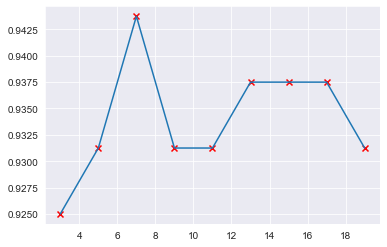

In [18]:
training_scores = []
k_values = np.arange(3, 21, 2)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    new_score = knn.score(X_test, y_test)
    training_scores.append(new_score)
plt.scatter(k_values, training_scores, color='red', marker='x')
plt.plot(k_values, training_scores)

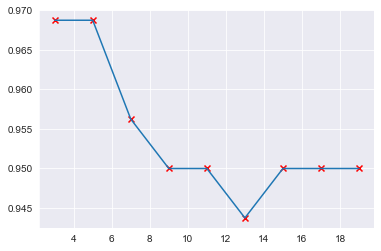

In [19]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies, target_df, test_size=0.2)
training_scores = []
k_values = np.arange(3, 21, 2)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    new_score = knn.score(X_test, y_test)
    training_scores.append(new_score)
plt.scatter(k_values, training_scores, color='red', marker='x')
plt.plot(k_values, training_scores)

try knn again but take out wins column to see if accuracy goes down.  If it does, then this would be a good example of feature engineering because I added the wins column on my own.

In [ ]:
pkmn_new = pkmn.copy(deep=True)
pkmn_new.drop_duplicates(subset='Number', keep='last', inplace=True)
pkmn_new.drop(labels='Number', axis=1, inplace=True)
pkmn_new

In [ ]:
numeric_cols = pkmn_new.select_dtypes(include=[np.int, np.float]).drop('Generation', axis=1)
new_scaler = StandardScaler()
new_scaler.fit(numeric_cols)
new_cols = new_scaler.transform(numeric_cols)
pkmn_new[list(numeric_cols.columns)] = new_cols


target_df = pkmn_new['Legendary']
pkmn_new.drop(['Legendary', 'Name'], axis=1, inplace=True)



In [ ]:
object_cols_labels = list(pkmn_new.select_dtypes(include=object).columns)
object_cols_labels.append('Generation')
scaled_with_dummies_2 = pd.get_dummies(pkmn_new, columns=object_cols_labels)
scaled_with_dummies_2.columns

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(scaled_with_dummies_2, target_df)
neigh.score(scaled_with_dummies_2, target_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies_2, target_df, test_size=0.2)
scores = []
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(X_train, y_train)
    score = neigh.score(X_test, y_test)
    scores.append(score)
plt.plot(k_values, scores)
plt.show()


preds = neigh.predict(X_test)
confusion_matrix(y_test, preds)

In [ ]:
preds = neigh.predict(X_test)
confusion_matrix(y_test, preds)

In [ ]:
dropped = scaled_with_dummies_2.drop(['Type 1_Electric', 'Generation_2', 'Type 2_Rock', 'Total'], axis=1)
dropped

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dropped, target_df, test_size=0.35)
scores = []
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(X_train, y_train)
    score = neigh.score(X_test, y_test)
    scores.append(score)
plt.plot(k_values, scores)

In [ ]:
scaled_with_dummies_2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies_2.drop(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def'], axis=1), target_df, test_size=0.3)
scores = []
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(X_train, y_train)
    score = neigh.score(X_test, y_test)
    scores.append(score)
plt.plot(k_values, scores)

In [ ]:
target_df_int = target_df.astype(int)
target_df_int

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies_2, target_df_int, test_size=0.3)
scores = []
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(X_train, y_train)
    score = neigh.score(X_test, y_test)
    scores.append(score)
plt.plot(k_values, scores)

In [ ]:
new_list = numeric_cols_labels[:]
new_list.append('Wins')

X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies[new_list], target_df_int, test_size=0.3)
scores = []
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(X_train, y_train)
    score = neigh.score(X_test, y_test)
    print(score)
    scores.append(score)
plt.plot(k_values, scores)


preds = neigh.predict(X_test)

In [ ]:
y_test

In [ ]:
new_list

In [ ]:
scaled_with_dummies

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
score = neigh.score(X_test, y_test)
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, pos_label=None, average='weighted')
precision = precision_score(y_test, preds, pos_label=None, average='weighted')
recall = recall_score(y_test, preds, pos_label=None, average='weighted')

In [ ]:
score, accuracy, f1, precision, recall

In [ ]:
print(classification_report(y_test, preds))

In [ ]:
confusion_matrix(y_test, preds)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(neigh, X_test, y_test, display_labels=['Non-Legendary', 'Legendary'], cmap=plt.cm.Blues)

In [ ]:
plot_confusion_matrix(neigh, X_test, y_test, display_labels=['Non-Legendary', 'Legendary'], cmap=plt.cm.Blues, normalize='true')

In [ ]:
scaled_with_dummies

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies, target_df, test_size=0.4)
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
plot_confusion_matrix(lr, X_test, y_test, cmap=plt.cm.Blues)

In [ ]:
lr_preds = lr.predict(X_test)
print(classification_report(y_test, lr_preds))

# Logistic Regression - Predicting Legendary Status

In [ ]:
pkmn_join.corr()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(pkmn_join.corr(), cmap=plt.get_cmap('gist_gray'))

Based on the correlation df and heatmap above, Legendary is most highly correlated with the following 3 quantitative variables:
    1. Total
    2. Sp. Atk
    3. Sp. Def
As total is the sum of all of the other stats, HP, Attack, Defense, Sp. Atk, Sp. Def, and Speed, I'd expect it to be collinear with the other variables.  Let's check:

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
pkmn_copy = pkmn_join.copy(deep=True)
pkmn_copy['Legendary'] = pkmn_copy['Legendary'].astype('int')

In [ ]:
variance_inflation_factor(pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']].values, 6)

In [ ]:
pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']]

In [ ]:
X

In [ ]:
def calc_vif(X):
    """
    X: A pandas DataFrame object of numerical independent variables to be used in regression,
    Calculates the variance inflation factor of each independent variable in X
    against all of the other independent variables in X"""
    vif = pd.DataFrame()
    vif['Variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return(vif)

In [ ]:
new_df = pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['HP', 'Defense', 'Sp. Atk', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['Defense', 'Sp. Atk', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['Defense', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
#scaled_with_dummies
new_df = scaled_with_dummies.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
X = new_df.iloc[:,:]
calc_vif(X)

In [ ]:
lr = LogisticRegression(random_state=4)
lr.fit(pkmn_join.loc[:,['Defense', 'Speed']], target_df)
lr.coef_

In [ ]:
lr = LogisticRegression(random_state=4)
lr.fit(scaled_with_dummies.loc[:,['Defense', 'Speed']], target_df)
lr.coef_

## Regression

In [ ]:
pkmn_join.plot.scatter('Total', 'Wins')

In [ ]:
pkmn_join.Wins

In [ ]:
pkmn_join['Wins']